# Data Source & Description

Combination of
https://www.eecs.yorku.ca/~kamel/sidd/dataset.php (200 images)

https://www.kaggle.com/datasets/tenxengineers/denoising-dataset-multiple-iso-levels (BETALSP only)

We add random artificial Gaussian noise to the ground images.

# Imports & Loading Dataset

In [ ]:
## Kaggle setup. Need your json api key
from google.colab import files
! pip install -q kaggle
files.upload()

{}

In [ ]:
## Install and handle downloading/unzipping dataset
%%capture
! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tenxengineers/denoising-dataset-multiple-iso-levels
! kaggle datasets download -d abhigyanshanker/sidd-denoise
! mkdir sidd
! mkdir denoising
! unzip sidd-denoise.zip -d sidd
! unzip denoising-dataset-multiple-iso-levels.zip -d denoising

In [ ]:
%%capture

from google.colab.patches import cv2_imshow
import os

# bm3d
! pip install bm3d
import bm3d

# array & math manipulation
import math
import numpy as np
import random

# image & dataset handling
import PIL as pil
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# Machine learning
! pip install d2l==1.0.3
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch import nn
from torchsummary import summary
from d2l import torch as d2l

from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.restoration import denoise_bilateral
from skimage.util import (img_as_ubyte, img_as_float)

from scipy.stats import gaussian_kde

if torch.cuda.is_available():
 dev = "cuda"
else:
 dev = "cpu"
device = torch.device(dev)

MODEL_PATH = "./drive/MyDrive/data/"

In [ ]:
def loadDataset():
  BETAL_PATH = "./denoising/BetaISP - Denoising Dataset/BetaISP - Denoising Dataset/Noisy with Ground Truths/Ground Truth/BMP Data"
  # BETAL_PATH_NOISE = "/content/denoising/BetaISP - Denoising Dataset/BetaISP - Denoising Dataset/Noisy with Ground Truths/Noised/BMP Data"
  SIDD_PATH = "./sidd/train"

  betal_sp = [BETAL_PATH + "/" + path.parts[-1] for path in Path(BETAL_PATH).rglob('*.*')]
  # betal_sp_noise = [BETAL_PATH_NOISE + "/" + path.parts[-1] for path in Path(BETAL_PATH_NOISE).rglob('*.*')]
  betal_sp.sort()
  # betal_sp_noise.sort()

  sidd_dir = os.listdir(SIDD_PATH)
  sidd = []
  sidd_noise = []
  for d in sidd_dir:
    for path in Path(SIDD_PATH + "/" + d).rglob('*.*'):
      if("NOISY" in path.parts[-1]):
        sidd_noise.append(SIDD_PATH + "/" + d + "/" + path.parts[-1])
      else:
        sidd.append(SIDD_PATH + "/" + d + "/" + path.parts[-1])
  sidd.sort()
  # sidd_noise.sort()

  return pd.DataFrame(data={'Ground': sidd + betal_sp})

def displayImageSideBySide(img_dict):
  keys = list(img_dict.keys())
  fig = plt.figure(figsize=(10, 7))
  rows = 1
  cols = len(keys)

  for i in range(cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(img_dict[keys[i]])
    plt.title(keys[i])
    plt.axis('off')

In [ ]:
class ReadImg(object):
  def __call__(self, path):
    return cv2.imread(path)

class Rescale(object):
  def __init__(self, w, h):
    self.w = w
    self.h = h

  def __call__(self, img):
    return pil.ImageOps.fit(pil.Image.fromarray(img), (self.w, self.h))

class ToNumpy(object):
  def __call__(self, pil_img):
    return np.asarray(pil_img, dtype=np.uint8)

In [ ]:
def add_gaussian_noise(image, mean=0, sigma=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

In [ ]:
df = loadDataset()

y_train, y_test = train_test_split(df['Ground'].to_numpy(), test_size=0.2, random_state=123, shuffle=True)

ImgToNp = transforms.Compose([
    ReadImg(),
    Rescale(360, 240),
    ToNumpy()
])

ToTensor = transforms.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [ ]:
y_train_np = np.array([ImgToNp(y) for y in y_train], dtype=np.uint8)
y_test_np = np.array([ImgToNp(y) for y in y_test], dtype=np.uint8)
x_train_np = np.array([add_gaussian_noise(y) for y in y_train_np], dtype=np.uint8)
x_test_np = np.array([add_gaussian_noise(y) for y in y_test_np], dtype=np.uint8)

# EDA

In [ ]:
def img_metrics(y, y_hat, channel_axis):
  assert len(y) == len(y_hat)
  mse = np.array([MSE(y[i], y_hat[i]) for i in range(len(y))])
  ssim = np.array([SSIM(y[i], y_hat[i], channel_axis=channel_axis) for i in range(len(y))])
  psnr = np.array([PSNR(y[i], y_hat[i]) for i in range(len(y))])
  return mse, ssim, psnr

def display_metrics(y, y_hat, channel_axis):
  mse, ssim, psnr = img_metrics(y, y_hat, channel_axis)
  print(f"Mean MSE: {sum(mse)/len(mse)}, Mean SSIM: {sum(ssim)/len(ssim)}, Mean PSNR: {sum(psnr)/len(psnr)}")

  plt.hist(mse)
  plt.xlabel("MSE")
  plt.ylabel("Frequency")
  plt.show()

  plt.hist(ssim)
  plt.xlabel("SSIM")
  plt.ylabel("Frequency")
  plt.show()

  plt.hist(psnr)
  plt.xlabel("PSNR")
  plt.ylabel("Frequency")
  plt.show()

  return (sum(mse)/len(mse), sum(ssim)/len(ssim), sum(psnr)/len(psnr))

def display_calulated_metrics(metrics_list):
  mse = [m[0] for m in metrics_list]
  ssim = [m[1] for m in metrics_list]
  psnr = [m[2] for m in metrics_list]
  print(f"Mean MSE: {sum(mse)/len(mse)}, Mean SSIM: {sum(ssim)/len(ssim)}, Mean PSNR: {sum(psnr)/len(psnr)}")

  plt.hist(mse)
  plt.xlabel("MSE")
  plt.ylabel("Frequency")
  plt.show()

  plt.hist(ssim)
  plt.xlabel("SSIM")
  plt.ylabel("Frequency")
  plt.show()

  plt.hist(psnr)
  plt.xlabel("PSNR")
  plt.ylabel("Frequency")
  plt.show()

  return (sum(mse)/len(mse), sum(ssim)/len(ssim), sum(psnr)/len(psnr))

Mean MSE: 561.8088660425592, Mean SSIM: 0.2922848898811128, Mean PSNR: 20.65990583161439


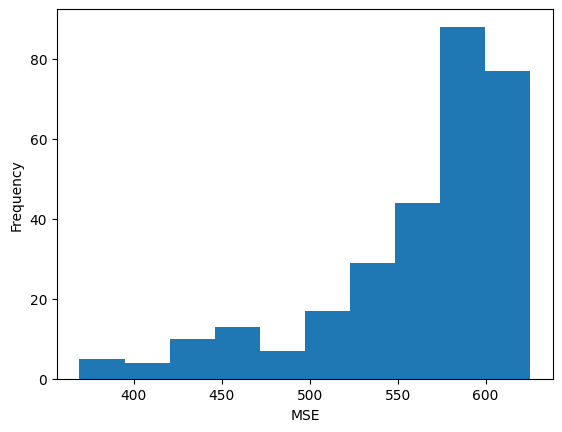

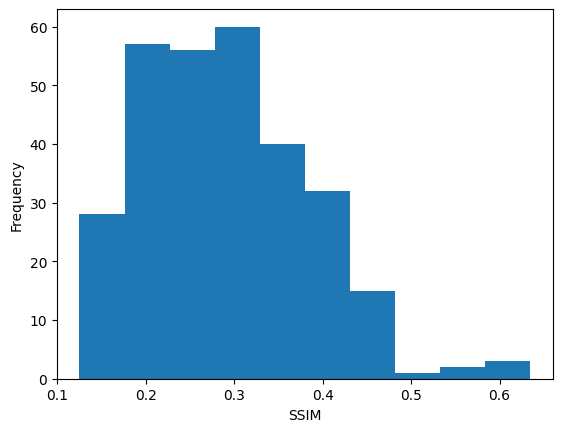

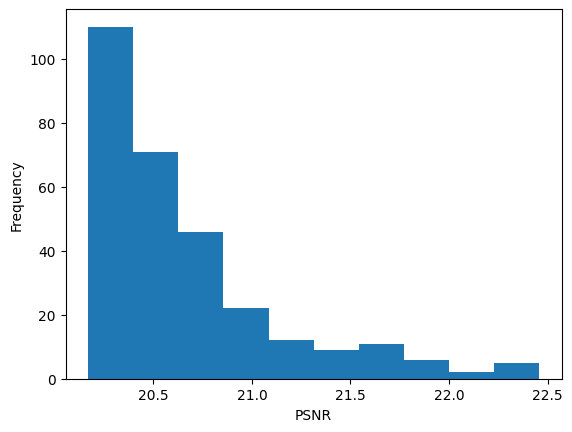

In [ ]:
original_train_metrics = display_metrics(x_train_np, y_train_np, -1)

Mean MSE: 574.2141122372371, Mean SSIM: 0.2810571066475487, Mean PSNR: 20.555655963800508


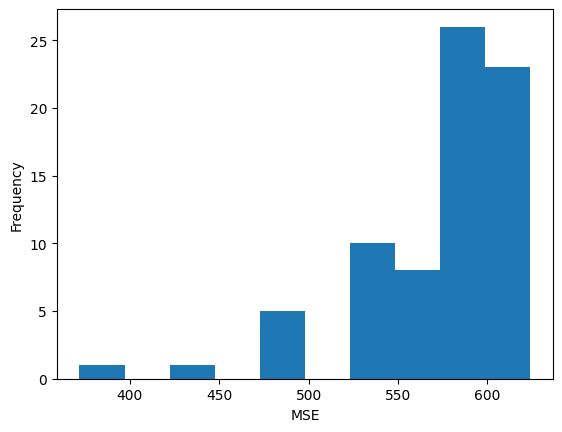

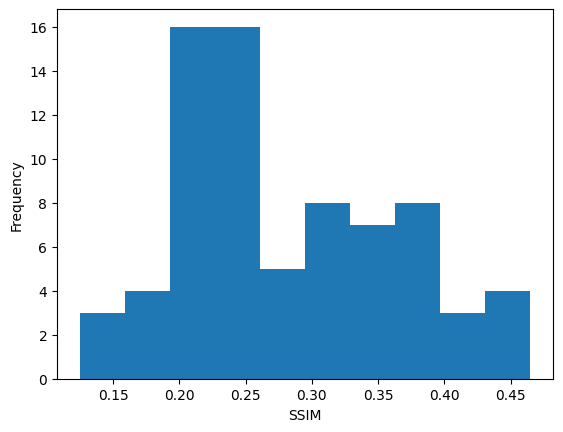

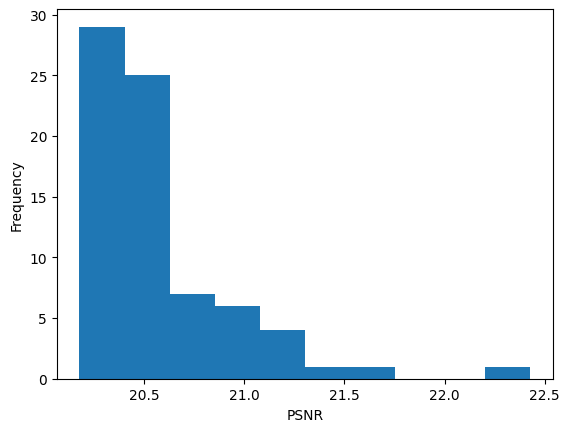

In [ ]:
original_test_metrics = display_metrics(x_test_np, y_test_np, -1)

In [ ]:
# Create a dictionary with the dataset information
dataset_info = {
    'ground_sidd_count': df[df['Ground'].str.contains('sidd')].shape[0],
    'ground_betaisp_count': df[df['Ground'].str.contains('BetaISP')].shape[0],
}

# Calculate totals
dataset_info['Total_Ground'] = dataset_info['ground_sidd_count'] + dataset_info['ground_betaisp_count']
dataset_info['Grand_Total'] = dataset_info['Total_Ground']
dataset_info['Total_SIDD'] = dataset_info['ground_sidd_count']
dataset_info['Total_BETAISP'] = dataset_info['ground_betaisp_count']

# Create a dictionary for the table
table_data = {
    '': ['', 'Ground', 'Total'],
    'Dataset1': ['Dataset1', dataset_info['ground_sidd_count'], dataset_info['Total_SIDD']],
    'Dataset2': ['Dataset2', dataset_info['ground_betaisp_count'], dataset_info['Total_BETAISP']],
    'Total': ['Total', dataset_info['Total_Ground'], dataset_info['Grand_Total']],
}

# Convert the dictionary to a DataFrame
summary_table = pd.DataFrame(table_data).set_index('')

# Display the table
print(summary_table)

        Dataset1  Dataset2  Total
                                 
        Dataset1  Dataset2  Total
Ground       320        48    368
Total        320        48    368


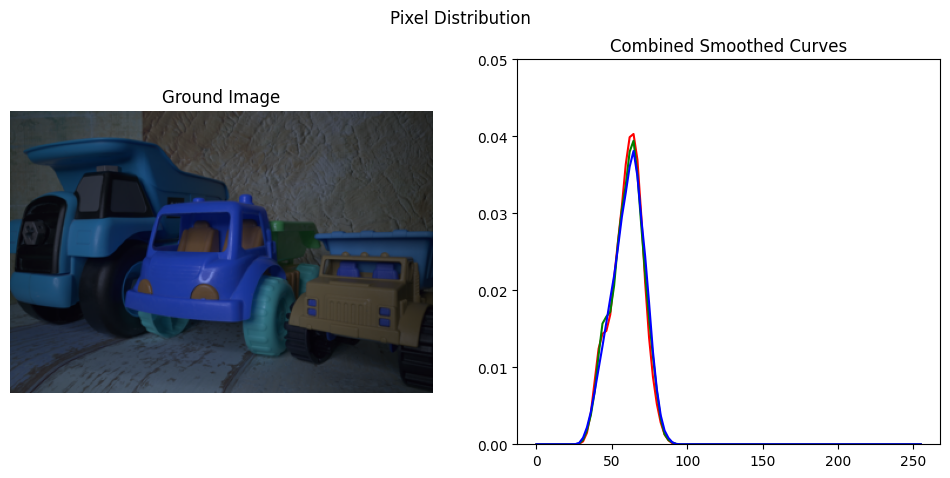

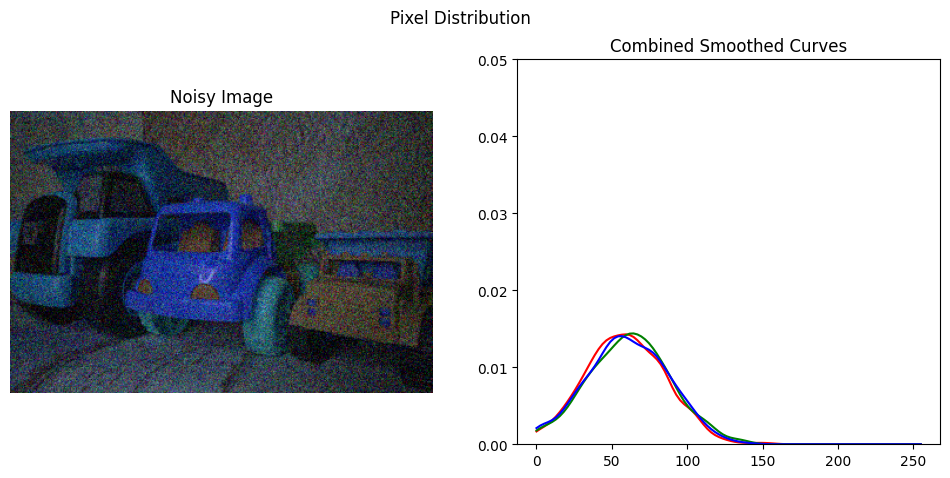

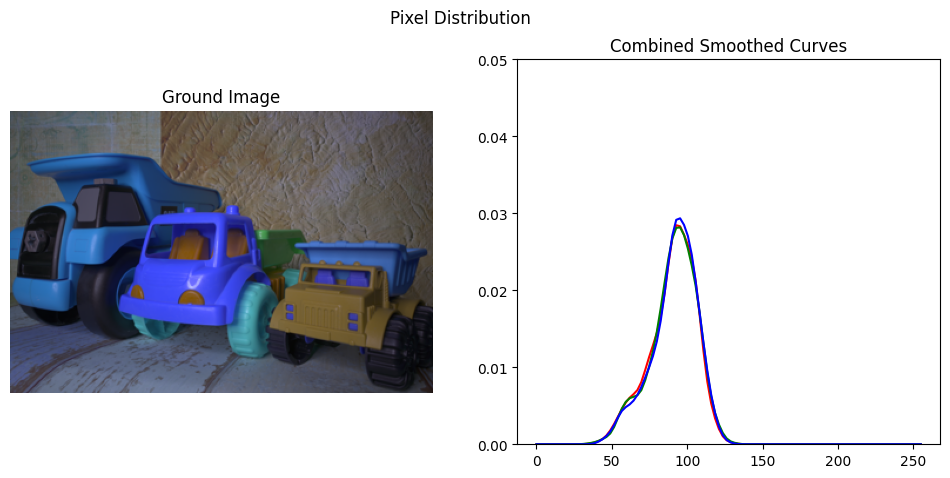

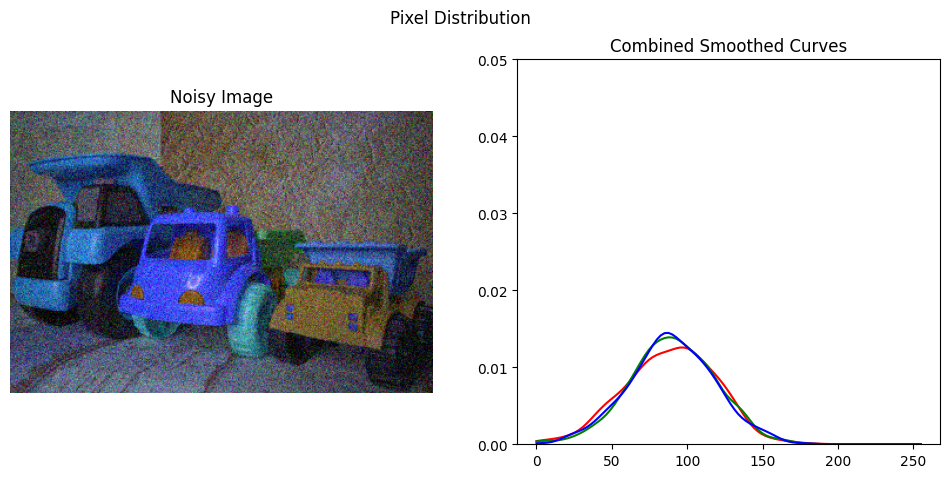

In [ ]:
# Randomly select two pairs of correlated images
random_indices = np.random.choice(len(x_train_np), size=2, replace=False)

# Function to extract pixel information and generate combined smoothed curves
def generate_combined_smooth_curves_with_image(img_array,title):
    # Extract pixel information
    red_channel = img_array[0, :, :].ravel()
    green_channel = img_array[1, :, :].ravel()
    blue_channel = img_array[2, :, :].ravel()

    # Generate smoothed curves using KDE
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Pixel Distribution')

    kernel_red = gaussian_kde(red_channel)
    kernel_green = gaussian_kde(green_channel)
    kernel_blue = gaussian_kde(blue_channel)

    x_values = np.linspace(0, 255, 100)

    # Plot original image
    axes[0].imshow(img_array)  # Transpose the image data
    axes[0].axis('off')

    axes[0].set_title(title)

    # Plot smoothed curves
    axes[1].plot(x_values, kernel_red(x_values), color='red', label='Red Channel')
    axes[1].plot(x_values, kernel_green(x_values), color='green', label='Green Channel')
    axes[1].plot(x_values, kernel_blue(x_values), color='blue', label='Blue Channel')
    axes[1].set_title('Combined Smoothed Curves')
    plt.ylim(0,0.05)
    plt.show()

# Generate combined smoothed curves with images for the selected pairs
for c in random_indices:
    generate_combined_smooth_curves_with_image(y_train_np[c],"Ground Image")
    generate_combined_smooth_curves_with_image(x_train_np[c],"Noisy Image")

# Image Denoising

## Bilateral Filtering

In [ ]:
def bilateral_denoise(imgs, sigma_s, sigma_r):
  return np.array([img_as_ubyte(denoise_bilateral(img_as_float(img), channel_axis=-1)) for img in imgs])

In [ ]:
y_train_hat_bil = bilateral_denoise(x_train_np, 10, 0.1)
y_test_hat_bil = bilateral_denoise(x_test_np, 10, 0.1)

Mean MSE: 265.6081194622911, Mean SSIM: 0.5073306042247439, Mean PSNR: 24.810797131670956


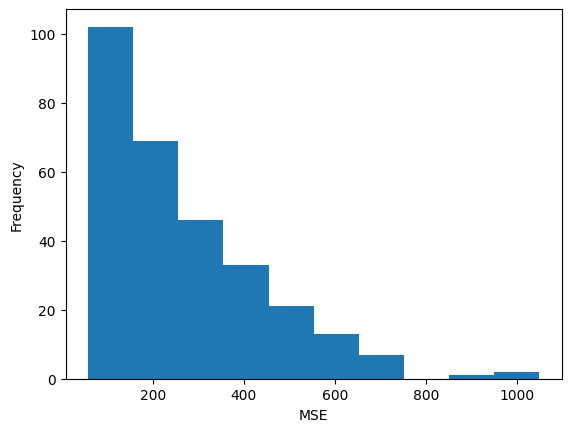

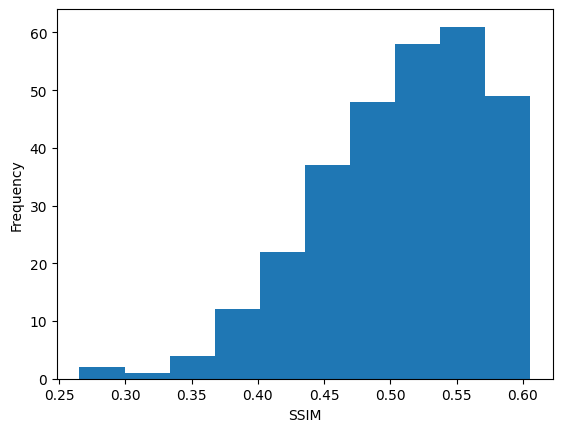

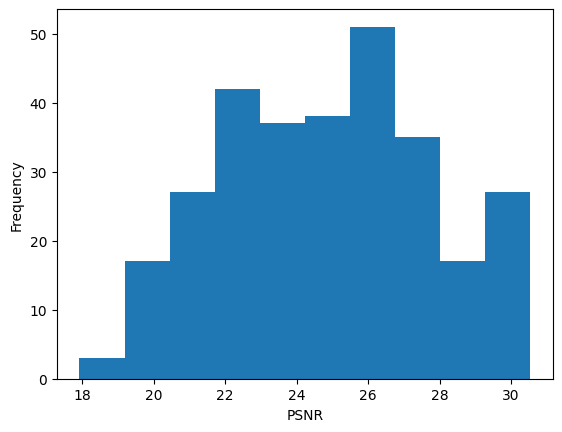

In [ ]:
bil_train_metrics = display_metrics(y_train_np, y_train_hat_bil, -1)

Mean MSE: 258.79139389389394, Mean SSIM: 0.5084882093136094, Mean PSNR: 24.831435843982813


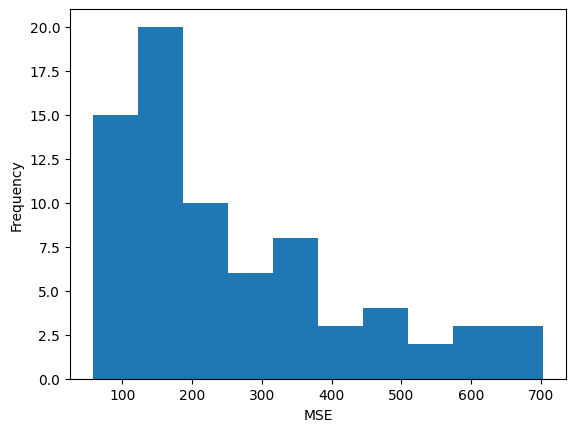

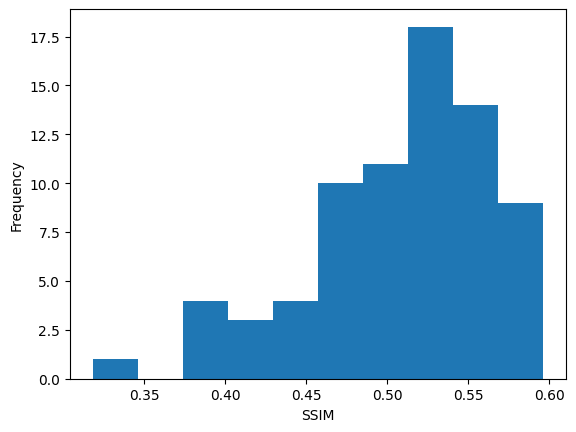

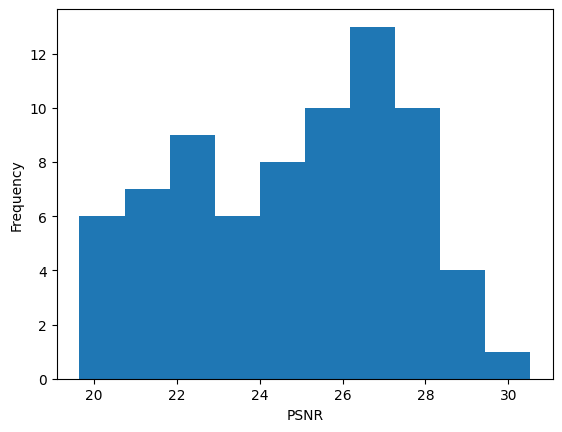

In [ ]:
bil_test_metrics = display_metrics(y_test_np, y_test_hat_bil, -1)

Training Set


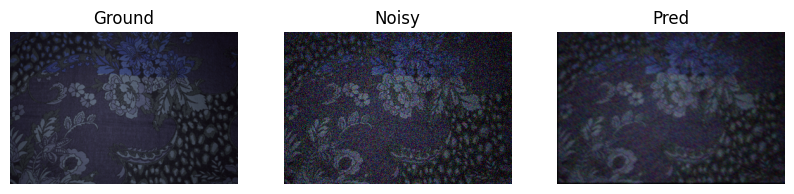

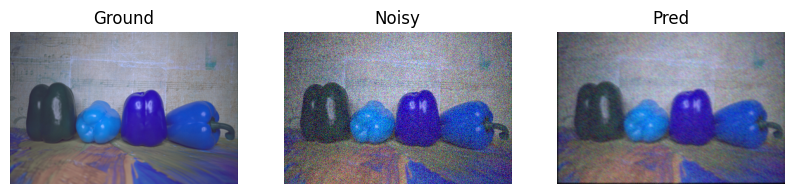

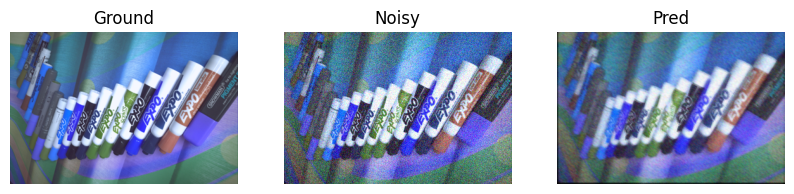

In [ ]:
print("Training Set")
for i in np.random.choice(len(y_train_np), size=3, replace=False):
  displayImageSideBySide({"Ground": y_train_np[i], "Noisy": x_train_np[i], "Pred": y_train_hat_bil[i]})

Validation Set


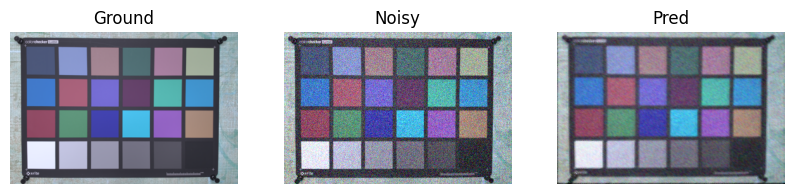

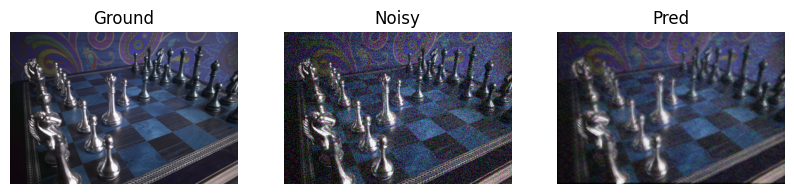

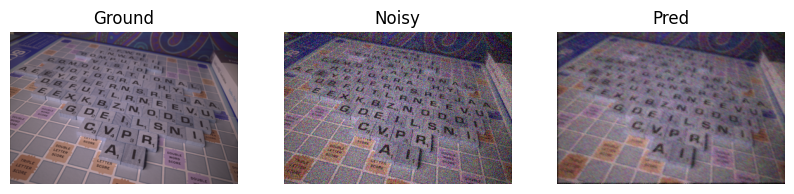

In [ ]:
print("Validation Set")
for i in np.random.choice(len(y_test_np), size=3, replace=False):
  displayImageSideBySide({"Ground": y_test_np[i], "Noisy": x_test_np[i], "Pred": y_test_hat_bil[i]})

## Deep Learning

In [ ]:
class ImageDataset(d2l.DataModule):
  def __init__(self, x_train, x_valid, y_train, y_valid, batch_size=12):
    super().__init__()
    self.save_hyperparameters()

    self.x_train = torch.stack([ToTensor(x) for x in x_train]).to(device)
    self.x_valid = torch.stack([ToTensor(x) for x in x_valid]).to(device)
    self.y_train = torch.stack([ToTensor(y) for y in y_train]).to(device)
    self.y_valid = torch.stack([ToTensor(y) for y in y_valid]).to(device)

  def get_dataloader(self, train):
    if(train):
      return self.get_imageloader((self.x_train, self.y_train), True)
    else:
      return self.get_imageloader((self.x_valid, self.y_valid), False)

  def train_dataloader(self):
    return self.get_dataloader(train=True)

  def val_dataloader(self):
    return self.get_dataloader(train=False)

  def get_imageloader(self, tensors, train):
    """Defined in :numref:`sec_synthetic-regression-data`"""
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

def display_DL_metrics(X, y, model):
  train_metrics = []
  for i in range(len(X)):
    y_hat = np.transpose(model(X[i:i+1])[0].to("cpu").detach().numpy(), (1, 2, 0))

    train_metrics.append((MSE(y_hat, y[i]),
                SSIM(y_hat, y[i], channel_axis=-1),
                PSNR(y_hat, y[i])))
  return display_calulated_metrics(train_metrics)

def display_DL_images(X, y, model): # X is cpu tensor, y is transposed np
  for i in np.random.choice(len(X), size=10, replace=False):
    y_hat = np.transpose(model(X[i:i+1])[0].detach().numpy(), (1, 2, 0))
    displayImageSideBySide({"Ground": y[i],
                          "Noisy": np.transpose(X[i].detach().numpy(), (1, 2, 0)),
                        "Pred": y_hat})

imgDataset = ImageDataset(x_train_np, x_test_np, y_train_np, y_test_np)

### AutoEncoder

In [ ]:
class AutoEncoder(d2l.Module):
  def __init__(self, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
      nn.LazyConv2d(32, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.MaxPool2d((2,2), padding = 0),
      nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.MaxPool2d((2,2), padding = 0),
      nn.LazyConv2d(128, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.MaxPool2d((2,2), padding = 0),
      nn.LazyConvTranspose2d(128, kernel_size = (2,2), stride = (2,2)),
      nn.ReLU(),
      nn.LazyConvTranspose2d(64, kernel_size = (2,2), stride = (2, 2)),
      nn.ReLU(),
      nn.LazyConvTranspose2d(32, kernel_size = (2,2), stride = (2,2)),
      nn.ReLU(),
      nn.LazyConv2d(3, kernel_size = 3, stride = 1, padding = 1),
      nn.Sigmoid()
    )

  def loss(self, Y_hat, Y):
    fn = nn.MSELoss()
    return fn(Y_hat, Y)

  def forward(self, X):
    return self.net(X)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
autoencoder = AutoEncoder(lr=0.003).to(device)
print(summary(autoencoder, (3, 360, 240)))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 360, 240]             896
              ReLU-2         [-1, 32, 360, 240]               0
         MaxPool2d-3         [-1, 32, 180, 120]               0
            Conv2d-4         [-1, 64, 180, 120]          18,496
              ReLU-5         [-1, 64, 180, 120]               0
         MaxPool2d-6           [-1, 64, 90, 60]               0
            Conv2d-7          [-1, 128, 90, 60]          73,856
              ReLU-8          [-1, 128, 90, 60]               0
         MaxPool2d-9          [-1, 128, 45, 30]               0
  ConvTranspose2d-10          [-1, 128, 90, 60]          65,664
             ReLU-11          [-1, 128, 90, 60]               0
  ConvTranspose2d-12         [-1, 64, 180, 120]          32,832
             ReLU-13         [-1, 64, 180, 120]               0
  ConvTranspose2d-14         [-1, 32, 3

In [ ]:
if(os.path.isfile(f"{MODEL_PATH}ae.pth")):
  autoencoder.load_state_dict(torch.load(f"{MODEL_PATH}ae.pth"))
  autoencoder = autoencoder.to("cpu")
else:
  trainer = d2l.Trainer(max_epochs=100)
  trainer.fit(autoencoder, imgDataset)

  if(device != "cpu"): # prevents gpu ram blowup
    autoencoder = autoencoder.to("cpu")

  torch.save(autoencoder.state_dict(),  f"{MODEL_PATH}ae.pth")

Mean MSE: 0.002095029998702105, Mean SSIM: 0.8573149667710674, Mean PSNR: 27.91069012207027


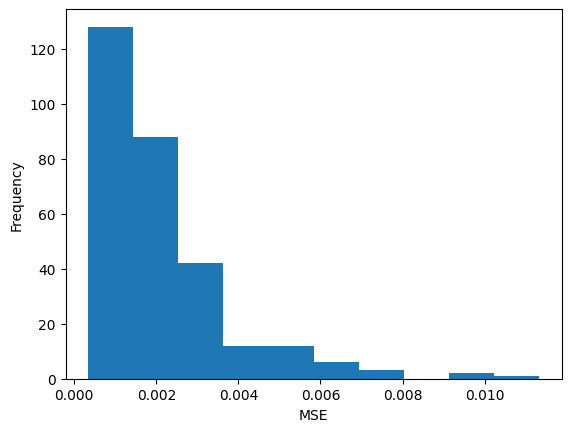

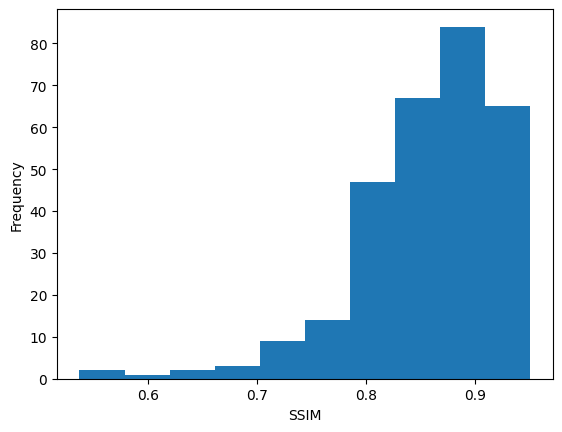

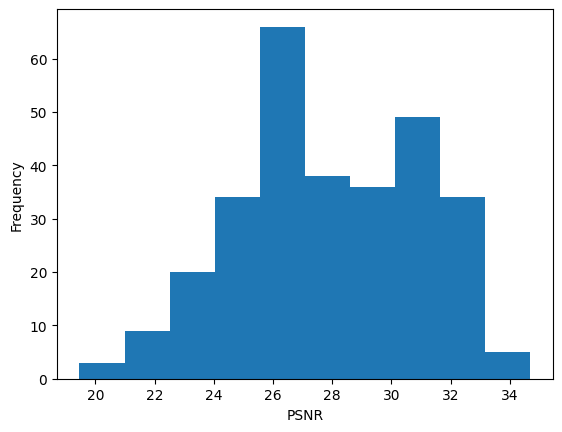

In [ ]:
ae_train_metrics = display_DL_metrics(imgDataset.x_train.to("cpu"),
                   np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   autoencoder)

Mean MSE: 0.001926230692318762, Mean SSIM: 0.8644512682347685, Mean PSNR: 28.158684803531504


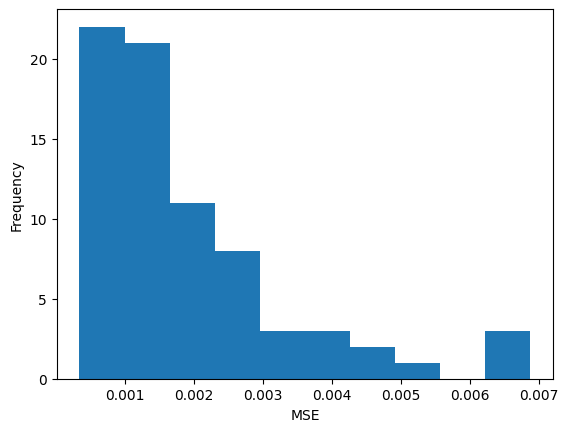

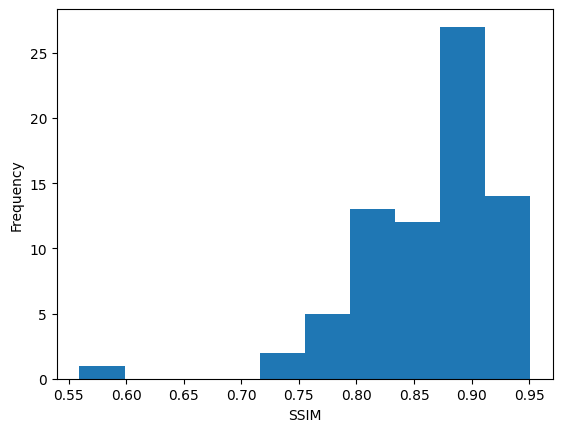

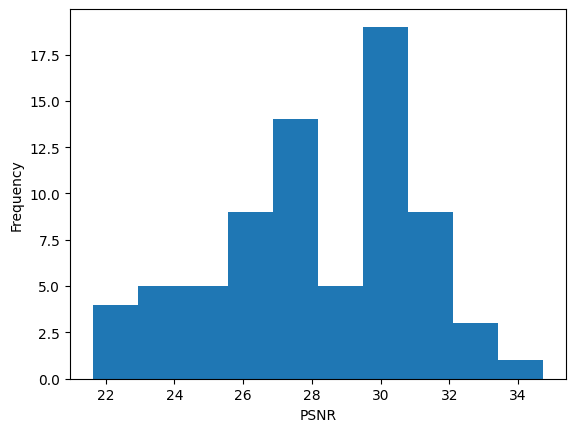

In [ ]:
ae_test_metrics = display_DL_metrics(imgDataset.x_valid.to("cpu"),
                   np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   autoencoder)

In [ ]:
print("Training Set")
display_DL_images(imgDataset.x_train.to("cpu"),
                  np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  autoencoder)

In [ ]:
print("Validation Set")
display_DL_images(imgDataset.x_valid.to("cpu"),
                  np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  autoencoder)

### UNET

In [ ]:
class UNET(d2l.Module):
  def __init__(self, lr):
    super().__init__()
    self.save_hyperparameters()
    self.c1 = nn.Sequential(
      nn.LazyConv2d(16, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(16, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.p1 = nn.MaxPool2d((2,2), padding = 0)

    self.c2 = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(32, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(32, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.p2 = nn.MaxPool2d((2, 2), padding = 0)

    self.c3 = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.p3 = nn.MaxPool2d((2,2), padding = 0)

    self.cm = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(128, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(128, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.dc3 = nn.LazyConvTranspose2d(64, kernel_size = (2,2), stride = (2, 2), padding = 0)

    self.uc3 = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.dc2 = nn.LazyConvTranspose2d(32, kernel_size = (2,2), stride = (2, 2), padding = 0)

    self.uc2 = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(32, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(32, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.dc1 = nn.LazyConvTranspose2d(16, kernel_size = (2,2), stride = (2, 2), padding = 0)

    self.uc1 = nn.Sequential(
      nn.Dropout(0.1),
      nn.LazyConv2d(16, kernel_size = (3,3), padding = "same"),
      nn.ReLU(),
      nn.LazyConv2d(16, kernel_size = (3,3), padding = "same"),
      nn.ReLU()
    )

    self.final = nn.Sequential(
        nn.LazyConv2d(3, (1, 1), padding = "same"),
        nn.Sigmoid()
    )

  def loss(self, Y_hat, Y):
    fn = nn.MSELoss()
    return fn(Y_hat, Y)

  def forward(self, X):
    c1 = self.c1(X)
    p1 = self.p1(c1)
    c2 = self.c2(p1)
    p2 = self.p2(c2)
    c3 = self.c3(p2)
    p3 = self.p3(c3)

    cm = self.cm(p3)

    dc3 = self.dc3(cm)
    uc3 = self.uc3(torch.cat([dc3, c3]))

    dc2 = self.dc2(uc3)
    uc2 = self.uc2(torch.cat([dc2, c2]))

    dc1 = self.dc1(uc2)
    uc1 = self.uc1(torch.cat([dc1, c1]))

    final = self.final(uc1)

    return final

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
imgDataset = ImageDataset(x_train_np, x_test_np, y_train_np, y_test_np, batch_size=1)
unet = UNET(lr=0.002).to(device)
print(summary(unet, (3, 360, 240)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 360, 240]             448
              ReLU-2         [-1, 16, 360, 240]               0
            Conv2d-3         [-1, 16, 360, 240]           2,320
              ReLU-4         [-1, 16, 360, 240]               0
         MaxPool2d-5         [-1, 16, 180, 120]               0
           Dropout-6         [-1, 16, 180, 120]               0
            Conv2d-7         [-1, 32, 180, 120]           4,640
              ReLU-8         [-1, 32, 180, 120]               0
            Conv2d-9         [-1, 32, 180, 120]           9,248
             ReLU-10         [-1, 32, 180, 120]               0
        MaxPool2d-11           [-1, 32, 90, 60]               0
          Dropout-12           [-1, 32, 90, 60]               0
           Conv2d-13           [-1, 64, 90, 60]          18,496
             ReLU-14           [-1, 64,

In [ ]:
if(os.path.isfile(f"{MODEL_PATH}unet.pth")):
  unet.load_state_dict(torch.load(f"{MODEL_PATH}unet.pth"))
  unet = unet.to("cpu")
else:
  trainer = d2l.Trainer(max_epochs=100)
  trainer.fit(unet, imgDataset)

  if(device != "cpu"): # prevents gpu ram blowup
    unet = unet.to("cpu")

  torch.save(unet.state_dict(), f"{MODEL_PATH}unet.pth")

Mean MSE: 0.0038769198068290115, Mean SSIM: 0.8192010029238097, Mean PSNR: 25.348262120281877


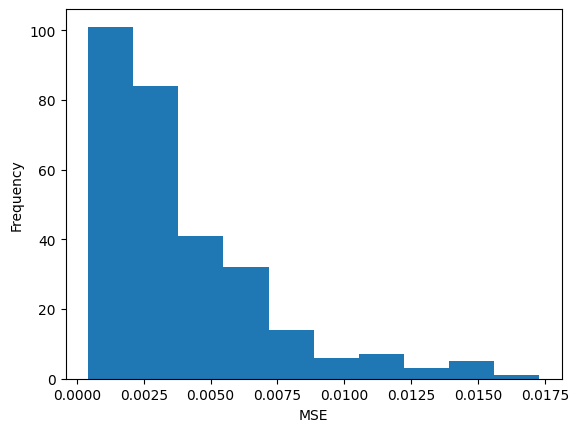

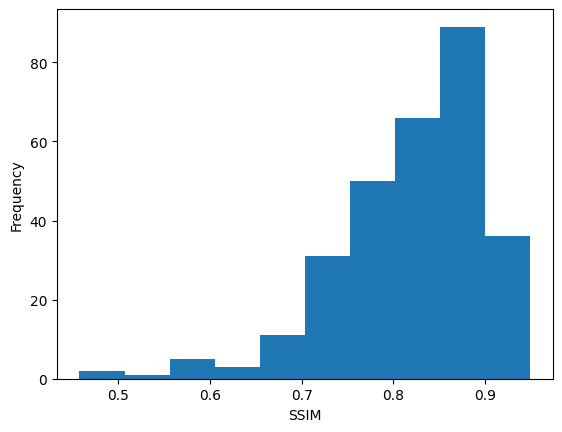

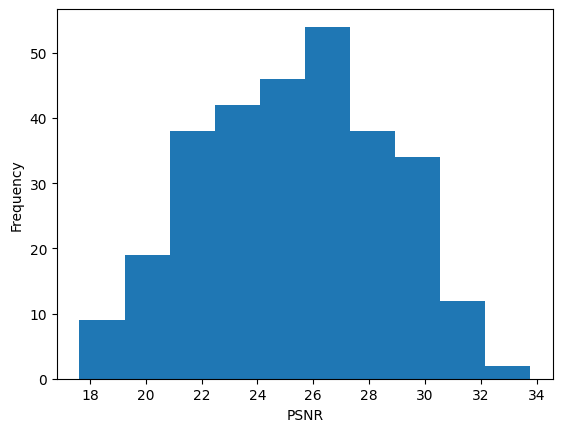

In [ ]:
unet_train_metrics = display_DL_metrics(imgDataset.x_train.to("cpu"),
                   np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   unet)

Mean MSE: 0.004011415076207064, Mean SSIM: 0.8274591742335139, Mean PSNR: 25.139180804857414


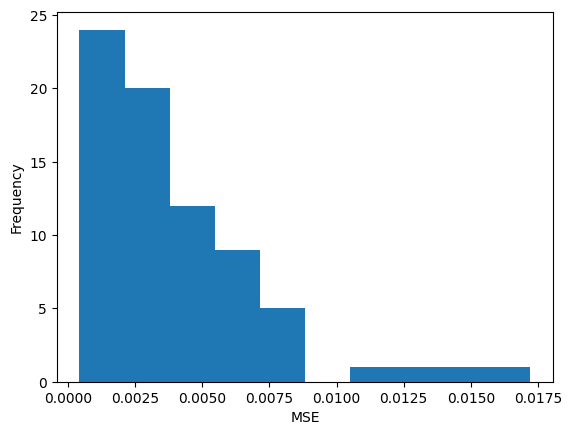

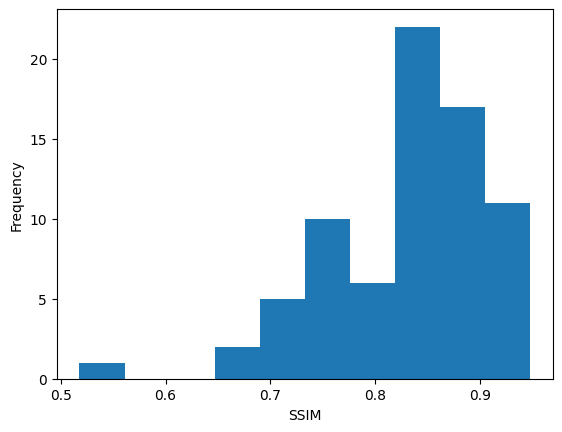

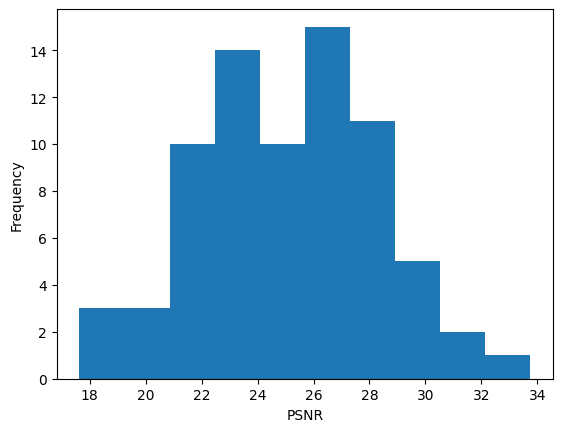

In [ ]:
unet_test_metrics = display_DL_metrics(imgDataset.x_valid.to("cpu"),
                   np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   unet)

In [ ]:
print("Training Set")
display_DL_images(imgDataset.x_train.to("cpu"),
                  np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  unet)

In [ ]:
print("Validation Set")
display_DL_images(imgDataset.x_valid.to("cpu"),
                  np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  unet)

### DnCNN

In [ ]:
class DnCNN(d2l.Module):
  def __init__(self, depth, lr):
    super().__init__()
    self.save_hyperparameters()
    net = [nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"),
           nn.ReLU()]

    for i in range(1, depth-1):
      net.append(nn.LazyConv2d(64, kernel_size = (3,3), padding = "same"))
      net.append(nn.BatchNorm2d(64, momentum=0.9))
      net.append(nn.ReLU())
    net.append(nn.LazyConv2d(3, kernel_size = (3,3), padding = "same"))

    self.net = nn.Sequential(*net)

  def loss(self, Y_hat, Y):
    fn = nn.MSELoss()
    return fn(Y_hat, Y)

  def forward(self, X):
    return torch.clamp(torch.sub(X, self.net(X)), min=0, max=1)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

imgDataset = ImageDataset(x_train_np, x_test_np, y_train_np, y_test_np)

In [ ]:
dncnn = DnCNN(8, 0.001).to(device)
print(summary(dncnn, (3, 360, 240)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 360, 240]           1,792
              ReLU-2         [-1, 64, 360, 240]               0
            Conv2d-3         [-1, 64, 360, 240]          36,928
       BatchNorm2d-4         [-1, 64, 360, 240]             128
              ReLU-5         [-1, 64, 360, 240]               0
            Conv2d-6         [-1, 64, 360, 240]          36,928
       BatchNorm2d-7         [-1, 64, 360, 240]             128
              ReLU-8         [-1, 64, 360, 240]               0
            Conv2d-9         [-1, 64, 360, 240]          36,928
      BatchNorm2d-10         [-1, 64, 360, 240]             128
             ReLU-11         [-1, 64, 360, 240]               0
           Conv2d-12         [-1, 64, 360, 240]          36,928
      BatchNorm2d-13         [-1, 64, 360, 240]             128
             ReLU-14         [-1, 64, 3

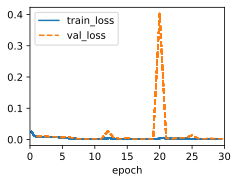

In [ ]:
if(os.path.isfile(f"{MODEL_PATH}dncnn.pth")):
  dncnn.load_state_dict(torch.load(f"{MODEL_PATH}dncnn.pth"))
  dncnn = dncnn.to("cpu")
else:
  trainer = d2l.Trainer(max_epochs=30)
  trainer.fit(dncnn, imgDataset)

  if(device != "cpu"): # prevents gpu ram blowup
    dncnn = dncnn.to("cpu")

  torch.save(dncnn.state_dict(),  f"{MODEL_PATH}dncnn.pth")

Mean MSE: 0.002225864061539376, Mean SSIM: 0.8293682170563004, Mean PSNR: 27.721829817153463


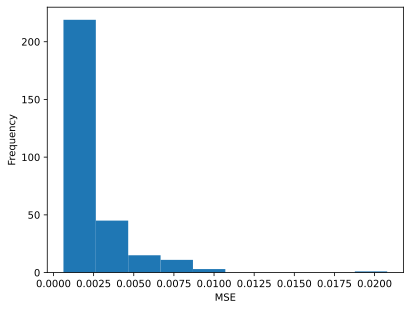

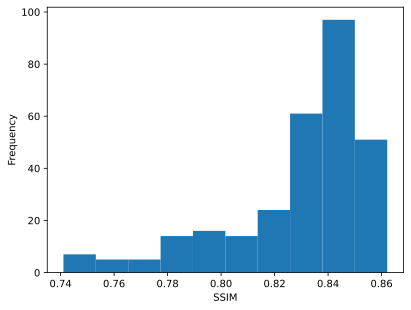

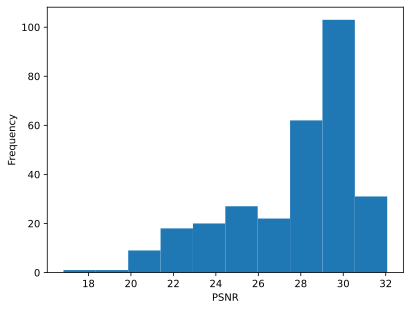

In [ ]:
dncnn_train_metrics = display_DL_metrics(imgDataset.x_train.to("cpu"),
                   np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   dncnn)

Mean MSE: 0.0024893448213762423, Mean SSIM: 0.825778720346657, Mean PSNR: 27.521297284668602


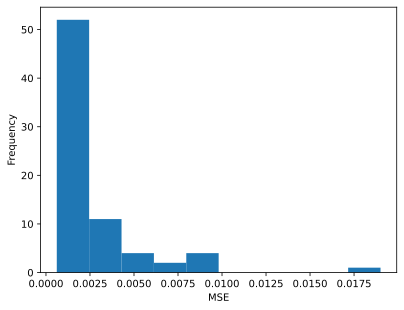

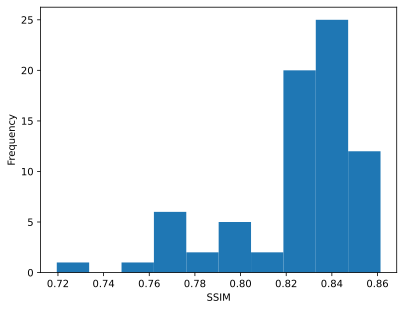

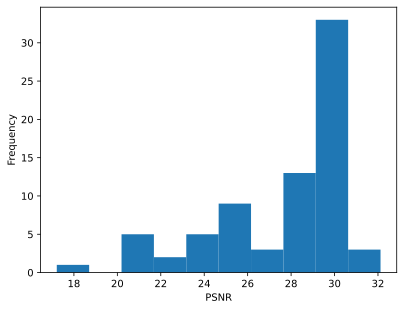

In [ ]:
dncnn_test_metrics = display_DL_metrics(imgDataset.x_valid.to("cpu"),
                   np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                   dncnn)

In [ ]:
print("Training Set")
display_DL_images(imgDataset.x_train.to("cpu"),
                  np.transpose(imgDataset.y_train.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  dncnn)

In [ ]:
print("Validation Set")
display_DL_images(imgDataset.x_valid.to("cpu"),
                  np.transpose(imgDataset.y_valid.to("cpu").detach().numpy(), (0, 2, 3, 1)),
                  dncnn)

# Result & Analysis

In [ ]:
results_train = [original_train_metrics, bil_train_metrics, ae_train_metrics, unet_train_metrics, dncnn_train_metrics]
train_metrics_result = pd.DataFrame(results_train,
                                    columns=["MSE", "SSID", "PSNR"],
                                    index=["Original", "Bilateral", "AutoEncoder", "UNET", "DnCNN"])
train_metrics_result

MSE      SSID       PSNR
Original     561.808866  0.292285  20.659906
Bilateral    265.608119  0.507331  24.810797
AutoEncoder    0.002095  0.857315  27.910690
UNET           0.003877  0.819201  25.348262
DnCNN          0.002226  0.829368  27.721830

In [ ]:
results_test = [original_test_metrics, bil_test_metrics, ae_test_metrics, unet_test_metrics, dncnn_test_metrics]
test_metrics_result = pd.DataFrame(results_test,
                                   columns=["MSE", "SSID", "PSNR"],
                                   index=["Original", "Bilateral", "AutoEncoder", "UNET", "DnCNN"])
test_metrics_result

MSE      SSID       PSNR
Original     574.214112  0.281057  20.555656
Bilateral    258.791394  0.508488  24.831436
AutoEncoder    0.001926  0.864451  28.158685
UNET           0.004011  0.827459  25.139181
DnCNN          0.002489  0.825779  27.521297

# References

https://www.kaggle.com/code/mandeepsinghsoorma/ffdnet-training#models.py


https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise.html

https://www.kaggle.com/code/milan400/fer2013-denoising-using-autoencoder-and-unet#AutoEncoder-Summary

https://colab.research.google.com/github/ashishpatel26/Awesome-Pytorch-Tutorials/blob/main/10.Pytorch%20AutoEncoder%20Neural%20Network%20for%20Image%20Denoising.ipynb#scrollTo=ob8Bqvpfz2gl

https://github.com/IDKiro/CBDNet-pytorch

https://towardsai.net/p/deep-learning/image-de-noising-using-deep-learning

https://saproovarun.medium.com/image-and-video-denoising-using-dncnn-216be1ff8ba1



*   Zhang, K., Zuo, W., Chen, Y., Meng, D., & Zhang, L. (2017, July). Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising. *IEEE Transactions on Image Processing*, 26(7), 3142–3155. https://doi.org/10.1109/tip.2017.2662206

*   Nishio, M., Nagashima, C., Hirabayashi, S., Ohnishi, A., Sasaki, K., Sagawa, T., Hamada, M., & Yamashita, T. (2017, August). Convolutional auto-encoder for image denoising of ultra-low-dose CT. *Heliyon*, 3(8), e00393. https://doi.org/10.1016/j.heliyon.2017.e00393

*   Yang, K., Liu, Y., Yu, Z., & Chen, C. L. P. (2023, April 1). Extracting and Composing Robust Features With Broad Learning System. *IEEE Transactions on Knowledge and Data Engineering*, 35(4), 3885–3896. https://doi.org/10.1109/tkde.2021.3137792

*   Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In *Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18* (pp. 234-241). Springer International Publishing.

*   于子涵. (2016). ノイズとヘイズを除去する画像強調.